In [29]:
from io import BytesIO

import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')

import hvplot.pandas

In [30]:
def get_number_of_rows(dataframe):
    df = pd.read_csv(dataframe)
    return df.shape[0]

In [62]:
import os
path = '../data'
files = os.listdir(path)
path_files = [path + '/'+ string for string in files]
number_of_rows = [get_number_of_rows(dataframe) for dataframe in path_files]
#dict_values = [(file_name, n_rows) for file_name, n_rows in zip(path_files, number_of_rows) ]
file_entries = dict(zip(files,path_files))
file_rows = dict(zip(path_files,number_of_rows))


In [58]:
file_rows

{'20220928-193156_JigsawPuzzle.csv': 1279,
 '20221003-131623_JigsawPuzzle.csv': 2560,
 '20220930-180439_JigsawPuzzle.csv': 4778,
 '20221003-134004_JigsawPuzzle.csv': 1928,
 '20221003-132953_JigsawPuzzle.csv': 2724,
 '20221003-132653_JigsawPuzzle.csv': 3461,
 '20221003-175958_JigsawPuzzle.csv': 3395,
 '20221004-114501_JigsawPuzzle.csv': 11129,
 '20221013-141842_JigsawPuzzle.csv': 1729,
 '20221020-150106_JigsawPuzzle.csv': 4208,
 '20221020-162555_JigsawPuzzle.csv': 1640,
 '20221020-162057_JigsawPuzzle.csv': 6395,
 '20221109-144049_JigsawPuzzle.csv': 2090,
 '20221123-173640_JigsawPuzzle.csv': 4413,
 '20221207-162655_JigsawPuzzle.csv': 2423,
 '20221215-153434_JigsawPuzzle.csv': 1709,
 '20221215-153316_JigsawPuzzle.csv': 1220,
 'test.csv': 2724,
 'test1.csv': 1933}

In [52]:
select = pn.widgets.Select(options=file_entries)

@pn.cache
def fetch_data(url):
    df = pd.read_csv(url)
    df.drop('time', axis = 1, inplace = True)
    df.insert(0,'time',df.index.values)
    df = df.fillna(0)
    return df

select_df = pn.Column(select, pn.bind(pn.widgets.Tabulator, pn.bind(fetch_data, select), page_size=10))

In [53]:
@pn.cache
def fetch_size(url):
    df = pd.read_csv(url)
    return df.size

In [54]:
idf = hvplot.bind(fetch_data, select).interactive()
dir(idf)
idf.shape[0]

In [55]:
png_pane_diagnostic = pn.pane.PNG('./pictures/diagnostic.png')


PNG(str)
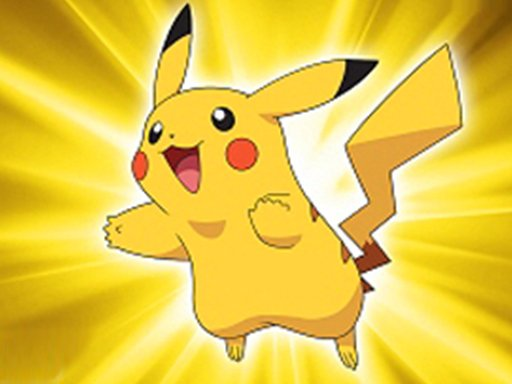

In [56]:
png_pane = pn.pane.PNG('./pictures/pikachu.png')
png_pane

## Slide to see only a region


def time_slider(select, value):
    if value == 'end':
        return pn.widgets.IntSlider(
            name = "Time slider",
            start = 0,
            value = file_rows[select],
            end = file_rows[select],
            step = 1    )
    else:
        return pn.widgets.IntSlider(
            name = "Time slider",
            start = 0,
            value = value,
            end = file_rows[select],
            step = 1    )
time_slider_l = pn.bind(time_slider, select, 0)
time_slider_r = pn.bind(time_slider, select, 'end')

time_slider_l
time_slider_r
time_slider_column = pn.Column(time_slider_l, time_slider_r)

In [ ]:
# Radio buttons for CO2 measures
yaxis_shoulder = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['shoulderLangle', 'shoulderRangle',],
    button_type='success'
)

In [68]:

shoulder_pipeline = (
    idf)

TypeError: unsupported operand type(s) for &: 'bool' and 'float'

In [ ]:
shoulder_pipeline

In [ ]:
shoulder_plot = shoulder_pipeline.hvplot(x = 'time',  y=yaxis_shoulder,line_width=2,  width=900, height=800, title="Shoulder Plot")
shoulder_plot


In [ ]:
yaxis_knee = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['kneeLangle', 'kneeRangle',],
    button_type='success'
)

In [91]:
knee_pipeline = (
    idf)

In [ ]:
knee_plot = shoulder_pipeline.hvplot(x = 'time',  y=yaxis_knee,line_width=2,  width=900, height=800, title="Knee Plot")
shoulder_plot

In [21]:
def df_pipeline(dataframe):
    return pn.pane.Markdown(dataframe)
df_name = pn.bind(df_pipeline, select)

In [23]:
df_string = pn.bind(lambda select: f'{select = }',select)
df_string

<function panel.depends._param_bind.<locals>.wrapped(*wargs, **wkwargs)>

In [25]:
html = '''
<!DOCTYPE HTML>
<html>
<head>
<meta charset="UTF-8">
<style type="text/css">
body {
	background-color: #f6f6ff;
	font-family: Calibri, Myriad;
}

#main {
	width: 780px;
	padding: 20px;
	margin: auto;
}

table.timecard {
	margin: auto;
	width: 600px;
	border-collapse: collapse;
	border: 1px solid #fff; /*for older IE*/
	border-style: hidden;
}

table.timecard caption {
	background-color: #150cc1;
	color: #fff;
	font-size: x-large;
	font-weight: bold;
	letter-spacing: .3em;
}

table.timecard thead th {
	padding: 8px;
	background-color: #9babc6;
	font-size: large;
}

table.timecard thead th#thDay {
	width: 40%;	
}

table.timecard thead th#thRegular, table.timecard thead th#thOvertime, table.timecard thead th#thTotal {
	width: 20%;
}

table.timecard th, table.timecard td {
	padding: 3px;
	border-width: 1px;
	border-style: solid;
	border-color: #4654f7 #ccc;
}

table.timecard td {
	text-align: right;
}

table.timecard tbody th {
	text-align: left;
	font-weight: normal;
}

table.timecard tfoot {
	font-weight: bold;
	font-size: large;
	background-color: #bac5df;
	color: #fff;
}

table.timecard tr.even {
	background-color: #46a4f7;
}
</style>
<title>Session Data</title>
</head>

<body>
<div id="main">
<table class="timecard">
	<caption>Session Data</caption>
	<thead>
		<tr>
			<th id="thMean">Mean</th>
			<th id="thVariance">Variance</th>
			<th id="thOvertime">Overtime</th>
		</tr>
	</thead>
	<tbody>
		<tr class="odd">
			<th>Shoulder</th>
			<td>8</td>
			<td>0</td>
		</tr>
		<tr class="even">
			<th>Sholder X</th>
			<td>8</td>
			<td>2.5</td>
		</tr>
		<tr class="odd">
			<th>Shoulder Y</th>
			<td>8</td>
			<td>0</td>
		</tr>
		<tr class="even">
			<th>Shoulder Z</th>
			<td>8</td>
			<td>0</td>
		</tr>
		<tr class="odd">
			<th>Knee</th>
			<td>8</td>
			<td>0</td>
		</tr>
		<tr class="even">
			<th>Knee X</th>
			<td>0</td>
			<td>5</td>
		</tr>
		<tr class="odd">
			<th>Knee Y</th>
			<td>0</td>
			<td>1</td>
		</tr>
	</tbody>

</table>
</div>
</body>
</html>
'''

In [26]:
html_pane = pn.pane.HTML(html)

In [88]:
#Layout using Template
template = pn.template.FastListTemplate(
    title='Wearable Device for Immersive Virtual Reality Control andApplication in Upper Limbs Motor Rehabilitation dashboard', 
    sidebar=[pn.pane.Markdown(""), 
             pn.pane.Markdown("#### Some meaningful instructions."), 
             select_df,
             png_pane_diagnostic,
             pn.pane.Markdown("## Settings"),
#             time_slider_column
            ],
    main=[pn.Row(pn.Column(yaxis_shoulder,
                           shoulder_plot.panel(width=700), margin=(0,25)), 
                  pn.Column(yaxis_knee,
                           knee_plot.panel(width=700), margin=(0,25))), 
          pn.Row(pn.Column(html_pane), 
                  png_pane)],
    accent_base_color="#87d8b1",
    header_background="#85d8b0",
)
# template.show()
template.servable();

NameError: name 'yaxis_shoulder' is not defined